In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from google.colab import files
import warnings
warnings.filterwarnings(action = 'once')

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.titleweight'] = 'bold'

In [ ]:
from google.colab import drive
drive.mount('content/', force_remount=True)

Mounted at content/


In [ ]:
energy_data_path = '/content/content/MyDrive/Project 2020-21/Car data/Paper Data/Four_homes.csv'
price_data_path = '/content/content/MyDrive/Project 2020-21/Car data/Paper Data/price_data.xlsx'

# pow_df = pd.read_excel('Four_homes.xlsx')
pow_df = pd.read_csv(energy_data_path)
price_df = pd.read_excel(price_data_path, sheet_name='cost in rupess')

In [ ]:
pow_df.head()

,H1,H2,H3,H4
0,1.137333,2.455300,0.159450,3.848300
1,1.109450,3.859267,0.163283,3.776800
2,0.925433,2.700883,0.181067,1.688600
3,0.859517,4.542017,0.154733,1.094767
4,0.870317,12.954770,0.182217,0.779333


In [ ]:
price_df.head()

,Time of the Day,Grid Purchase Cost,Grid Selling Cost,P2P Cost,Grid Purchase Cost.1,Grid Selling Cost.1,P2P Cost.1,Unnamed: 7
0,0,6,4,5,0.13409,0.080454,0.107272,ToU Tariff:
1,1,6,4,5,0.13409,0.080454,0.107272,(Cost of purchase from grid by apartment build...
2,2,6,4,5,0.13409,0.080454,0.107272,"6am-10am, 8 Rs"
3,3,6,4,5,0.13409,0.080454,0.107272,"10am - 6pm, 7 Rs"
4,4,6,4,5,0.13409,0.080454,0.107272,"6pm - 10pm, 8 Rs"


In [ ]:
file_path = '/content/content/My Drive/Project 2020-21/Car data/car_data.csv'
vehicle_df = pd.read_csv(file_path)
temp = vehicle_df.temp + 273
vehicle_df.head()

,arr_time,dep_time,soc_initial,soc_final,temp,temp_max,temp_min,Distance travelled,Distance need to travel
0,10,17,0.689,0.481,20.225,29.93,10.52,14,20
1,9,16,0.705,0.426,21.730,31.00,12.46,20,17
2,11,15,0.754,0.386,21.725,30.92,12.53,18,15
3,12,17,0.736,0.464,21.565,31.05,12.08,19,16
4,11,17,0.689,0.442,21.885,31.29,12.48,18,19


In [ ]:
price_df.head()

,Time of the Day,Grid Purchase Cost,Grid Selling Cost,P2P Cost,Grid Purchase Cost.1,Grid Selling Cost.1,P2P Cost.1,Unnamed: 7
0,0,6,4,5,0.13409,0.080454,0.107272,ToU Tariff:
1,1,6,4,5,0.13409,0.080454,0.107272,(Cost of purchase from grid by apartment build...
2,2,6,4,5,0.13409,0.080454,0.107272,"6am-10am, 8 Rs"
3,3,6,4,5,0.13409,0.080454,0.107272,"10am - 6pm, 7 Rs"
4,4,6,4,5,0.13409,0.080454,0.107272,"6pm - 10pm, 8 Rs"


In [ ]:
purchase_price = price_df['Grid Purchase Cost'].values
sell_price = price_df['Grid Selling Cost'].values

### Important functions

In [ ]:
# def myplot(xvals,yvals, kind='plot', labels=None,xlab=None,ylab=None,titles=None,colors='b',image_name = 'imag.png',save=False, Xticks=None):
#     plt.rc('xtick',labelsize = 15)
#     plt.rc('ytick',labelsize = 15)
        
#     if not isinstance(xvals, list):
#         print("Calling from first control statement")
#         print(f"type(xvals): {type(xvals)}")
#         if kind.lower() == 'bar': 
#             plt.bar(xvals,yvals,label = labels, linewidth = 2, color = colors)
#         else:
#             plt.plot(xvals,yvals,label = labels, linewidth = 2, color = colors)
#     else:# if xvals is nested list        
#         print("Calling from second control statement")
#         for j in range(len(labels)):
#             plt.plot(xvals,yvals[:,j],label = labels[j], linewidth = 2, color = colors[j])
    
#     plt.xticks(np.arange(0,len(xvals)), Xticks)
#     plt.xlabel(xlab,fontsize = 16)
#     plt.ylabel(ylab,fontsize = 16)
#     plt.title(titles,fontsize = 18,color = 'black',fontweight = 'bold')
#     name = image_name
#     if save:
#         plt.legend()
#         plt.grid()
#         plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
#         files.download(name) 
#     plt.legend()
#     plt.grid()
#     plt.show()

# colors = 'red blue'.split()
# x = np.linspace(0,2,4)
# y1 = np.sin(x); y2 = np.cos(x);
# xvals = x
# yvals = np.vstack((y1,y2)).T
# xlabs = 'time'
# ylabs = "magnitude"
# labs = 'sine curve, cosine curve'.split(',')
# title = "Sinusoidal curves"

# myplot(xvals, yvals, xlab=xlabs, ylab=ylabs, titles=title, labels=labs, colors = colors, image_name='test.jpg', save=False)


In [ ]:
def cycle_deg( T, b_current, c_rate, del_t):
    cycle_const = [8.6772e-6, -5.1613e-3, 7.6788e-1, -6.7e-3, 2.35] #[a, b, c, d, e]
    a,b,c,d,e = cycle_const[0], cycle_const[1], cycle_const[2], cycle_const[3], cycle_const[4]
    cells_per_mod = 72

    B1 = a*pow(T,2) + b*T + c
    B2 = d*T + e
    cell_current = b_current / cells_per_mod
    cycle_loss = B1 * np.exp(B2 * c_rate) * cell_current * (del_t/60) # del_t in hour
    return cycle_loss

def cal_deg2(temp, t):
    alpha, beta = 165000, -4148
    cal_deg = alpha * np.exp(beta/temp) * pow(t,0.5)
    return cal_deg # in %

def hour2min2hour(hour1, hour2):
    """
    hour1 = arrival time,
    hour2 = departure time
    """
    frac_hour1 = hour1 - int(hour1)
    frac_hour2 = hour2 - int(hour2)
    min = ( (int(hour2) - int(hour1))*60 + (frac_hour2 - frac_hour1)*100 ) / 60
    return min

def hour2steps(hour,step_size):
    """
    -> Convert hour into minute.Unit of step_size in minutes
    -> Divide minutes with step size and u will get steps.
    """
    steps = int(hour * 60 / step_size)
    return steps

def myTemp(ambient_temp, power):
    rth = 2 # Celcius / kW
    return ambient_temp + rth * power

def myplot(xvals,yvals, kind='plot', labels=None,xlab=None,ylab=None,titles=None,colors='b',image_name = 'imag.png',save=False, Xticks=None):
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)

    if kind.lower() == 'bar': 
        plt.bar(xvals,yvals,label = labels, linewidth = 2, color = colors)
    else:
        plt.plot(xvals,yvals,label = labels, linewidth = 2, color = colors)
       
    plt.xticks(np.arange(0,len(xvals)), Xticks)
    plt.xlabel(xlab,fontsize = 16)
    plt.ylabel(ylab,fontsize = 16)
    plt.title(titles,fontsize = 18,color = 'black',fontweight = 'bold')
    name = image_name
    if save:
        plt.legend()
        plt.grid()
        plt.savefig(name,bbox_inches = 'tight',orientation = 'portrait')
        files.download(name) 
    plt.legend()
    plt.grid()
    plt.show()

def printf(p):
    def varname(p):
        for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
            m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
            if m:
             return m.group(1)
    print(varname(p) + ": " + str(p))

def changeTimeStamp(arr, old_del_t, new_del_t):
    if new_del_t > old_del_t:
        print("New timestamp should be less than old timestamp!")
    elif old_del_t%new_del_t != 0:
        print("New timestamp should be multiple of old timestamp!")
    else:
        repeat = old_del_t // new_del_t
        new_arr = np.repeat(arr, repeat, axis = 0)
        return new_arr

def billCalc(total_soc_increment, b_cap_kwh, price, current_step, steps):
    '''
    ==> This function will claculate the total bill as per the energy consumption.
    ==> First total enery consumption is calculated and based on charging and discharging it is 
        divided into equal steps and for each step bill is calculated and updated simultaneously.
    ==> Current step can be more than 24 so make program accordingly.
    ==> Parameters:
        1. SOC(%)
        2. total_soc_increment(%)
        3. price (INR)
    '''
    per_step_increment = total_soc_increment / steps
    energy = per_step_increment * b_cap_kwh / 100
    current_step %= 24

    bill = 0
    for s in range(current_step, current_step + steps):
        bill += energy * price[s]
    return bill

maximum demand of H1: 6.204kW


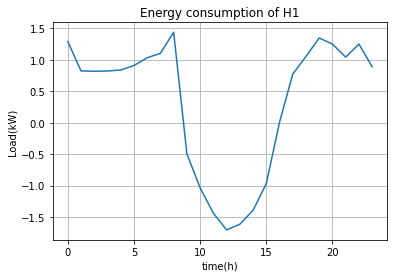

In [ ]:
# 1 day profile of H1 data
p1 = pow_df.H1.values[24*2:24*3]
time = np.arange(len(p1))

plt.plot(p1)
plt.xlabel("time(h)")
plt.ylabel("Load(kW)")
plt.title("Energy consumption of H1")
plt.grid()
plt.plot()

print(f"maximum demand of H1: {pow_df.H1.max():.3f}kW")

## Charging and discharging price plot

[]

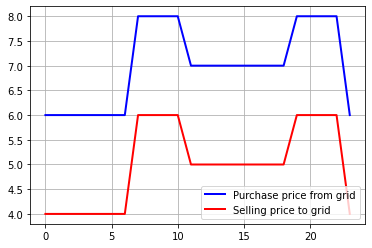

In [ ]:
plt.plot(purchase_price, color = 'b', label = "Purchase price from grid", linewidth=2)
plt.plot(sell_price, color = 'r', label = 'Selling price to grid', linewidth=2)
plt.grid()
plt.legend()
plt.plot()


# <font color = 'blue' > Case 1 Degradation program for a year with EV discharging into home </font>

##<font color = 'red'> Assumptions </font>
1. Every day car is charging after 12.00 AM as after that price is minimum.
![picture](https://drive.google.com/uc?export=view&id=1SB4u5rVnVjeMCnpKLmjw4ddbyP6M5msp)

2. Steps size = 1h.
3. Car is charging at everyday from 12.00 to until it reaches upper threshold.
4. Discharging time is fixed as price is high upto **11.00 PM**.

In [ ]:
# print("array points where demand is higher then charger capacity")
# print(np.where(p1>home_charger))

# print(f"There are {len(p1[p1>home_charger])} points.")

## Main Program

### Notes
1. There is some problem with part 7(Discharging at home.).Try and rectify it.

## Experimental

In [ ]:
# new_battery_price = 600000 
# old_battery_price = 0.25 * new_battery_price 

# deg_cost = -(cum_total_deg[-1] / 20) * (new_battery_price - old_battery_price)
# home_profit = home_bill_with_disch + deg_cost
# home_profit

In [ ]:
# diff_soc = np.diff(soc) * 60 / del_t
# plt.plot(diff_soc)

## New Program that formed on 20/02/2021

In [ ]:
days = 1 * 365
p1 = pow_df.H1.values[:24*days]
# p1 = [2,2,1,1,1,2,2,3,3,4,4,5,5,4,4,4,5,6,6,-1,2,2,3,3]
new_p1 = list(p1)
del_t = 60 #min
steps = days*24*60//del_t

b_cap = 30.2 # kWh
b_volt = 320
travel_energy = 30 * 0.126
upper_th = 95 # upper SOC threshold
lower_th = 20 # lower SOC threshold

build_arr_time = np.random.randint( 10,11, size = days )
build_dep_time = np.random.randint( 16,17, size = days )
home_leave_time = np.random.randint( 9,10, size = days ) # No randomness
home_arr_time = np.random.randint( 17,18, size = days ) # EV arrived 5.00 pm at home

home_charger = 3.3 # kw
rth = 2 # Celcius/kW


b_percent_cap = np.zeros(len(p1)+1)
b_percent_cap[0] = 100


def withV2H_DailyCharge(p1):
    soc = np.zeros(steps+1) 
    soc[0] = 50 # initial SOC at 12.00 AM
    start_time = 0 # Program start at 12.00 AM

    cum_cal_time = np.zeros(days+1)
    cum_cal_deg = np.zeros(days+1)
    cum_cycle_deg = np.zeros(days+1)
    cum_disch_energy = np.zeros(days+1)
    cum_charge_energy = np.zeros(days+1)
    
    home_bill = 0
    current_step = 0
    total_disch_energy = total_charge_energy = 0 # Discharge energy into home
    
    # Main Program
    for day in range(days):
        b_cap_kwh = b_percent_cap[day] * b_cap/100    
        daily_cycle_deg, daily_cal_time = 0,0 
        
        daily_charged_energy = 0
        isCharging = True
        if isCharging:
            charged_energy = (0.95 - soc[current_step]/100) * b_cap_kwh
            home_charge_time = np.ceil(charged_energy / home_charger)
            charge_steps = hour2steps(home_charge_time, del_t)
            total_soc_increment = upper_th - soc[current_step]
            per_step_increment = total_soc_increment / charge_steps
            charged_energy_per_step = charged_energy/charge_steps

            b_temp = myTemp(temp[day], home_charger)
            if b_temp > 273+45:
                b_temp = 273+45
            b_current = home_charger*1000 / b_volt
            c_rate = home_charger / b_cap_kwh
            
            for i in range(charge_steps):
                # if p1[current_step] > 0:
                charged_energy = charged_energy_per_step + p1[current_step]*del_t/60
                daily_charged_energy += charged_energy
                home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
                soc[current_step+1] = soc[current_step] + per_step_increment
                daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
                current_step += 1
        # Currently I am at index 4(95 of SOC)
        isCharging = False 
        # print(f"current step after charging:{current_step}")
        # print(f"Energy after charging at home: {daily_charged_energy}")

        ### Everything is fine (Checked) #####
    
        # ============================================
        ## 2.Staying at home for some time(completed)
        # ============================================
        home_cal_time = home_leave_time[day] - home_charge_time
        home_cal_steps = hour2steps(home_cal_time, del_t)
        daily_cal_time += home_cal_time
        soc[current_step+1:current_step+home_cal_steps+1] = soc[current_step] # SOC will constant as no self discharge during standing at home.
        # Home bill calculation
        for i in range(home_cal_steps):

            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill +=  charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1
        # print(f"current step after leaving the home:{current_step}")
        # print(f"Energy after leaving the home: {daily_charged_energy}")

        
        # current_step += home_cal_steps #****** (current_step=9)

        ### Everything is fine (Checked) #####

        # ==================================
        ## 3. Going from home to office
        # ==================================
        travel_time = 1
        travel_steps = hour2steps(travel_time,del_t)
        travel_power = travel_energy / travel_time # Const
        total_soc_decrement = travel_energy / b_cap_kwh * 100 # fixed soc will decrease as b_cap is fixed
        per_step_decrement = total_soc_decrement / travel_steps
        b_temp = myTemp(temp[day], travel_power)
        if b_temp > 273+45:
            b_temp = 273+45
        b_current = travel_power*1000 / b_volt
        c_rate = travel_power / b_cap_kwh
        for i in range(travel_steps):
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
            daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
            soc[current_step+1] = soc[current_step] - per_step_decrement
            current_step +=1
        daily_cycle_deg *= 2 # from building to home
        # Home bill calculation
        # print(f"current step after reaching the building:{current_step}")
        # print(f"Energy after travelling to building: {daily_charged_energy}")
        
        # current_step += travel_steps #******(cuurent_step=10)

        ### Everything is fine (Checked) #####
        # =================================
        ## 4. At office
        # =================================
        build_stand_time = build_dep_time[day] - build_arr_time[day]
        build_stand_steps = hour2steps(build_stand_time, del_t)
        daily_cal_time += build_stand_time
        soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step] # SOC will constant as no self discharge.
        # Home bill calculation
        for i in range(build_stand_steps):
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1
        # current_step += build_stand_steps #******(current_step=16)
        # print(f"current_step after leaving the building:{current_step}")
        # print(f"Energy after leaving the building: {daily_charged_energy}")

        ### Everything is fine (Checked) #####
        # ==================================
        ## 5. Returning from office to home
        # ==================================
        # Degradation is already calculated(see 3)
        for i in range(travel_steps):
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += p1[current_step] * del_t/60 * purchase_price[current_step % len(purchase_price)]
            soc[current_step+1] = soc[current_step] - per_step_decrement
            current_step += 1
        # current_step += travel_steps #******(current step=17)
        ### Everything is fine (Checked) #####
        # print(f"Energy after reaching at home: {daily_charged_energy}")

        
        # =================================
        ## 6. Discharging at home
        # =================================
        # Car will be discharged into home to satisfy the evening peak of the load.(4h).
        home_disch_time = 4 # 4h after arriving at home
        disch_steps = hour2steps(home_disch_time, del_t)
        
        for i in range(disch_steps):
            if p1[current_step] > home_charger:
                disch_power = home_charger
                new_p1[current_step] = p1[current_step] - home_charger
                disch_energy = disch_power * del_t/60
                # print("Calling from if")
                # print(f"current_step: {current_step}, load:{p1[current_step]:.3f}kW")
                # print("new_p1 changed from p1 > home_charger")
                soc[current_step+1] = soc[current_step] - disch_energy / b_cap_kwh * 100
                b_temp = myTemp(temp[day], disch_power)
                if b_temp > 273+45:
                    b_temp = 273+45
                b_current = disch_power * 1000 / b_volt
                c_rate = disch_power / b_cap_kwh
                daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)

                # Home owner only needs to pay about new energy he is using!
                charged_energy = new_p1[current_step] * del_t/60 
                daily_charged_energy += charged_energy
                home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
            
            elif p1[current_step] <= 0: # Excessive solar generation
                # print("Calling from elif")
                # print(f"current_step: {current_step}, load:{p1[current_step]:.3f}kW")
                # here car is idle so I can accomodate calendar degaradation into this.
                disch_power = disch_energy = 0
                daily_cal_time += del_t/60 
                # new_p1[current_step] = p1[current_step]
                soc[current_step+1] = soc[current_step]

            else: # Home power < charger capacity
                # print("Calling from else")
                # print(f"current_step: {current_step}, load:{p1[current_step]:.3f}kW")
                disch_power = p1[current_step]
                disch_energy = disch_power * del_t/60
                new_p1[current_step] = 0
                soc[current_step+1] = soc[current_step] - disch_energy / b_cap_kwh * 100
                b_temp = myTemp(temp[day], disch_power)
                if b_temp > 273+45:
                    b_temp = 273+45
                b_current = disch_power * 1000 / b_volt
                c_rate = disch_power / b_cap_kwh
                daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)

            current_step += 1
            total_disch_energy += disch_energy
        # print(f"Energy after discharging at home: {daily_charged_energy}")

        # =================================
        ## 7. Idle at home 
        # =================================
        # After EV has satisfied peak demand then it will stay at home for some time
        # This time is before 12.00 AM
        home_stand_time2 = (day+1)*24 - current_step * del_t // 60
        home_stand_time2_steps = hour2steps(home_stand_time2, del_t)
        soc[current_step+1:current_step+1+home_stand_time2_steps] = soc[current_step] # SOC will constant as no self discharge during standing at home.
        # current_step += home_stand_time2_steps #******
        daily_cal_time = 24 - home_charge_time - 2*travel_time - home_disch_time

        for i in range(home_stand_time2_steps):
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1
        cum_charge_energy[day+1] = cum_charge_energy[day] + daily_charged_energy
        # print(f"current_step: {current_step}, soc[0] = {soc[current_step-24]}")
        # print(current_step, soc)

        # =================================
        ## 8. Degradation part 
        # =================================
        cum_cal_time[day+1] = cum_cal_time[day] + daily_cal_time 
        daily_cal_deg = cal_deg2(temp[day], cum_cal_time[day+1]/24) - cal_deg2(temp[day], cum_cal_time[day]/24)  # Cum_deg of total day - previous day degradation
        cum_cal_deg[day+1] = cum_cal_deg[day] + daily_cal_deg
        cum_cycle_deg[day+1] = cum_cycle_deg[day] + daily_cycle_deg
        
        daily_total_deg = daily_cal_deg + daily_cycle_deg
        b_percent_cap[day+1] = b_percent_cap[day] - daily_total_deg
        # print(f"Energy after 1 day: {daily_charged_energy}")

    total_deg = cum_cal_deg + cum_cycle_deg
    return cum_cal_deg[-1], cum_cycle_deg[-1], total_deg[-1], cum_charge_energy[-1], total_disch_energy, b_percent_cap, home_bill
# print(home_bill, total_disch_energy)

cum_cal_deg1, cum_cycle_deg1, total_deg1, cum_charge_energy1, cum_disch_energy1, b_percent_cap1, home_bill1 = withV2H_DailyCharge(p1)

print("=======================")
print(f"Simulation time {days} days")
print("=======================")
print(f"Home bill for V2H system: {home_bill1:.2f} INR")
print(f"total degradation: {total_deg1:.2f}%")
print(f"total discharge energy:{cum_disch_energy1:.2f} kWh")
print(f"total charge energy: {cum_charge_energy1:.2f} kWh")

# print(f"p1: {p1}")
# print(f"new_p1: {new_p1}")

# plt.figure(figsize = (20,8))
# plt.bar(np.arange(len(p1)), p1, color = 'orange', label = 'Before V2H')
# plt.bar(np.arange(len(p1)),new_p1, color = 'blue', label = "After V2H")
# plt.grid()
# plt.legend()
# plt.show()

Simulation time 365 days
Home bill for V2H system: 65190.98 INR
total degradation: 3.23%
total discharge energy:2490.44 kWh
total charge energy: 10359.89 kWh



# <font color = 'blue' >Case2: EV Charged when empty with V2H </font>

Here EV should not be charged during the high price time.

Program time : 365 days
charging happens for 121 times
Daily charging energy 10325.556654186386 kWh
home_bill: 68898.97175871849 INR
total degradation 2.954769482252749 %


<BarContainer object of 366 artists>

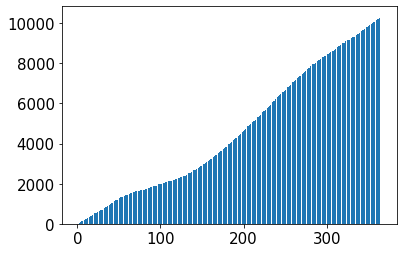

In [ ]:
days = 1 * 365
time = np.arange(0,days+1)
p1 = pow_df.H1.values[:24*days]
# p1 = [2,2,1,1,1,2,2,3,3,4,4,5,5,4,4,4,5,6,6,-1,2,2,3,3]
del_t = 60 #min
steps = days*24*60//del_t

b_cap = 30.2 # kWh
b_volt = 320
travel_energy = 30 * 0.126
upper_th = 95 # upper SOC threshold
lower_th = 20 # lower SOC threshold

build_arr_time = np.random.randint( 10,11, size = days )
build_dep_time = np.random.randint( 16,17, size = days )
home_leave_time = np.random.randint( 9,10, size = days ) # No randomness
home_arr_time = np.random.randint( 17,18, size = days ) # EV arrived 5.00 pm at home

home_charger = 3.3 # kW
rth = 2 # Celcius/kW

b_percent_cap = np.zeros(len(p1)+1)
b_percent_cap[0] = 100

soc = np.zeros(len(p1)+1)
soc[0] = upper_th

current_step= home_bill = 0

cum_cal_time = np.zeros(days+1)
cum_cal_deg = np.zeros(days+1)
cum_cycle_deg = np.zeros(days+1)
cum_disch_energy = np.zeros(days+1)
cum_charge_energy = np.zeros(days+1)

#########################
# Main Program
#########################
isCharging = True # Initializing the charging vector
charging = 0
for day in range(days):
    b_cap_kwh = b_percent_cap[day] * b_cap/100    
    daily_cycle_deg, daily_cal_time,daily_charged_energy = 0,0,0 
    
    current_energy = soc[current_step]/100 * b_cap_kwh
    if current_energy < 2*travel_energy:
        isCharging = True
    else:
        isCharging = False

    if isCharging: # Calculate total bill and cycle degradation
        charging += 1
        charged_energy = upper_th/100 * b_cap_kwh - current_energy
        cum_charge_energy[day+1] = cum_charge_energy[day] + charged_energy
        current_energy = upper_th * b_cap_kwh
        home_charge_time = np.ceil(charged_energy / home_charger)
        charge_steps = hour2steps(home_charge_time, del_t)
        total_soc_increment = upper_th - soc[current_step]
        per_step_increment = total_soc_increment / charge_steps
        charged_energy_per_step = charged_energy/charge_steps

        home_power = charged_energy_per_step * 60/del_t 
        b_temp = myTemp(temp[day], home_power)
        if b_temp > 273+45:
            b_temp = 273+45
        b_current = home_power*1000 / b_volt
        c_rate = home_power / b_cap_kwh
        
        # Home bill calculation
        for i in range(charge_steps):
            soc[current_step+1] = soc[current_step] + per_step_increment
            charged_energy = charged_energy_per_step + p1[current_step]*del_t/60
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1
    # Car will not charge until it leaves the home bu home will consume some energy    
    else:
        cum_charge_energy[day+1] = cum_charge_energy[day]
        home_charge_time = 0
        home_cal_time = home_leave_time[day]
        daily_cal_time += home_leave_time[day]
        home_cal_steps = hour2steps(home_cal_time, del_t)
        soc[current_step+1:current_step+home_cal_steps+1] = soc[current_step]

        # Home bill calculation
        for i in range(home_cal_steps):
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill +=  charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1

        # print(f"SOC:{soc}")
        # print(f"charged_energy: {daily_charged_energy}")

    # ==================================
    ## 3. Going from home to office
    # ==================================
    travel_time = 1
    travel_steps = hour2steps(travel_time,del_t)
    travel_power = travel_energy / travel_time # Const
    total_soc_decrement = travel_energy / b_cap_kwh * 100 # fixed soc will decrease as b_cap is fixed
    per_step_decrement = total_soc_decrement / travel_steps
    b_temp = myTemp(temp[day], travel_power)
    if b_temp > 273+45:
        b_temp = 273+45
    b_current = travel_power*1000 / b_volt
    c_rate = travel_power / b_cap_kwh
    for i in range(travel_steps):
        charged_energy = p1[current_step] * del_t/60 
        daily_charged_energy += charged_energy
        home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
        soc[current_step+1] = soc[current_step] - per_step_decrement
        current_step += 1
    daily_cycle_deg *= 2 # from building to home
    current_energy -= travel_energy
   
    # =================================
    ## 4. At office
    # =================================
    build_stand_time = build_dep_time[day] - build_arr_time[day]
    build_stand_steps = hour2steps(build_stand_time, del_t)
    daily_cal_time += build_stand_time
    soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step] # SOC will constant as no self discharge.
    # Home bill calculation
    for i in range(build_stand_steps):
        charged_energy = p1[current_step] * del_t/60 
        daily_charged_energy += charged_energy
        home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        current_step += 1

    # ==================================
    ## 5. Returning from office to home
    # ==================================
    # Degradation is already calculated(see 3)
    for i in range(travel_steps):
        charged_energy = p1[current_step] * del_t/60 
        daily_charged_energy += charged_energy
        home_bill += p1[current_step] * del_t/60 * purchase_price[current_step % len(purchase_price)]
        soc[current_step+1] = soc[current_step] - per_step_decrement
        current_step += 1
    current_energy -= travel_energy

    # =================================
    ## 6. Discharging at home
    # =================================
    # Car will park in home for some time(Earlier in this time car used to discharge)
    soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step]
    home_park_time = 4 # 4h after arriving at home
    home_stand_steps = hour2steps(home_park_time, del_t)
    # Home bill calculation
    for i in range(home_stand_steps):
        charged_energy = p1[current_step] * del_t/60 
        daily_charged_energy += charged_energy
        home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        current_step += 1
    daily_cal_time += home_park_time
    
    # soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step]
    home_stand_time2 = (day+1)*24 - current_step * del_t // 60
    home_stand_time2_steps = hour2steps(home_stand_time2, del_t)
    soc[current_step+1:current_step+1+home_stand_time2_steps] = soc[current_step] # SOC will constant as no self discharge during standing at home.
    # current_step += home_stand_time2_steps #******
    daily_cal_time = 24 - home_charge_time - 2*travel_time

    for i in range(home_stand_time2_steps):
        charged_energy = p1[current_step] * del_t/60 
        daily_charged_energy += charged_energy
        home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        current_step += 1
    cum_charge_energy[day+1] = cum_charge_energy[day] + daily_charged_energy
    # print(f"current_step: {current_step}, soc[0] = {soc[current_step-24]}")
    # print(current_step, soc)

    # =================================
    ## 8. Degradation part 
    # =================================
    cum_cal_time[day+1] = cum_cal_time[day] + daily_cal_time 
    daily_cal_deg = cal_deg2(temp[day], cum_cal_time[day+1]/24) - cal_deg2(temp[day], cum_cal_time[day]/24)  # Cum_deg of total day - previous day degradation
    cum_cal_deg[day+1] = cum_cal_deg[day] + daily_cal_deg
    cum_cycle_deg[day+1] = cum_cycle_deg[day] + daily_cycle_deg
    
    daily_total_deg = daily_cal_deg + daily_cycle_deg
    b_percent_cap[day+1] = b_percent_cap[day] - daily_total_deg
    # print(f"Energy after 1 day: {daily_charged_energy}")

    # total_deg = cum_cal_deg + cum_cycle_deg

total_deg = cum_cal_deg + cum_cycle_deg

print("=======================")
print(f"Program time : {days} days")
print("=======================")

print(f"charging happens for {charging} times")
print(f"Daily charging energy {cum_charge_energy[-1]} kWh")
# print(f"SOC profile for 1 day: {soc}")
print(f"home_bill: {home_bill} INR")
# print(f"home load for  1 day: {p1}")
print(f"total degradation {total_deg[-1]} %")

plt.bar(time, cum_charge_energy)



Program time : 365 days
charging happens for 122 times
Daily charging energy 11977.611154335451 kWh
home_bill: 80696.0616896127 INR
total degradation 2.9549207690296484 %


<BarContainer object of 366 artists>

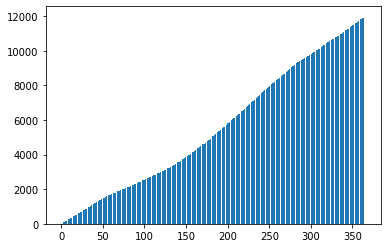

In [ ]:
days = 1 * 365
time = np.arange(0,days+1)
p1 = pow_df.H1.values[:24*days]
# p1 = [2,2,1,1,1,2,2,3,3,4,4,5,5,4,4,4,5,6,6,-1,2,2,3,3]
new_p1 = list(p1)
del_t = 60 #min
steps = days*24*60//del_t

b_cap = 30.2 # kWh
b_volt = 320
travel_energy = 30 * 0.126
upper_th = 95 # upper SOC threshold
lower_th = 20 # lower SOC threshold

build_arr_time = np.random.randint( 10,11, size = days )
build_dep_time = np.random.randint( 16,17, size = days )
home_leave_time = np.random.randint( 9,10, size = days ) # No randomness
home_arr_time = np.random.randint( 17,18, size = days ) # EV arrived 5.00 pm at home

home_charger = 3.3 # kW
rth = 2 # Celcius/kW

b_percent_cap = np.zeros(len(p1)+1)
b_percent_cap[0] = 100

soc = np.zeros(len(p1)+1)
soc[0] = 50

current_step= home_bill = 0

cum_cal_time = np.zeros(days+1)
cum_cal_deg = np.zeros(days+1)
cum_cycle_deg = np.zeros(days+1)
cum_disch_energy = np.zeros(days+1)
cum_charge_energy = np.zeros(days+1)

#########################
# Main Program
#########################
isCharging = True # Initializing the charging vector
charging = 0
for day in range(days):
    b_cap_kwh = b_percent_cap[day] * b_cap/100    
    daily_cycle_deg, daily_cal_time = 0,0 
    daily_charged_energy = 0
    
    current_energy = soc[current_step]/100 * b_cap_kwh
    if current_energy < 2*travel_energy:
        isCharging = True
    else:
        isCharging = False

    if isCharging: # Calculate total bill and cycle degradation
        charging += 1
        charged_energy = upper_th/100 * b_cap_kwh - current_energy
        cum_charge_energy[day+1] = cum_charge_energy[day] + charged_energy
        
        current_energy = upper_th * b_cap_kwh
        home_charge_time = np.ceil(charged_energy / home_charger)
        charge_steps = hour2steps(home_charge_time, del_t)
        total_soc_increment = upper_th - soc[current_step]
        per_step_increment = total_soc_increment / charge_steps
        charged_energy_per_step = charged_energy/charge_steps

        b_temp = myTemp(temp[day], home_charger)
        if b_temp > 273+45:
            b_temp = 273+45
        b_current = home_charger*1000 / b_volt
        c_rate = home_charger / b_cap_kwh
        
        for i in range(charge_steps):
            soc[current_step+1] = soc[current_step] + per_step_increment
            if p1[current_step] > 0:
                charged_energy = charged_energy_per_step + p1[current_step]*del_t/60
            else:
                charged_energy = charged_energy_per_step
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1
    # Car will not charge until it leaves the home bu home will consume some energy    
    else:
        cum_charge_energy[day+1] = cum_charge_energy[day]
        home_charge_time = 0
        home_cal_time = home_leave_time[day]
        daily_cal_time += home_leave_time[day]
        home_cal_steps = hour2steps(home_cal_time, del_t)
        soc[current_step+1:current_step+home_cal_steps+1] = soc[current_step]

        # Home bill calculation
        for i in range(home_cal_steps):
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill +=  charged_energy * purchase_price[current_step % len(purchase_price)]
            current_step += 1

        # print(f"SOC:{soc}")
        # print(f"charged_energy: {daily_charged_energy}")

    # ==================================
    ## 3. Going from home to office
    # ==================================
    travel_time = 1
    travel_steps = hour2steps(travel_time,del_t)
    travel_power = travel_energy / travel_time # Const
    total_soc_decrement = travel_energy / b_cap_kwh * 100 # fixed soc will decrease as b_cap is fixed
    per_step_decrement = total_soc_decrement / travel_steps
    b_temp = myTemp(temp[day], travel_power)
    if b_temp > 273+45:
        b_temp = 273+45
    b_current = travel_power*1000 / b_volt
    c_rate = travel_power / b_cap_kwh
    for i in range(travel_steps):
        charged_energy = p1[current_step] * del_t/60 
        daily_charged_energy += charged_energy
        home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        daily_cycle_deg += cycle_deg(b_temp, b_current, c_rate, del_t)
        soc[current_step+1] = soc[current_step] - per_step_decrement
        current_step += 1
    daily_cycle_deg *= 2 # from building to home
    current_energy -= travel_energy
   
    # =================================
    ## 4. At office
    # =================================
    build_stand_time = build_dep_time[day] - build_arr_time[day]
    build_stand_steps = hour2steps(build_stand_time, del_t)
    daily_cal_time += build_stand_time
    soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step] # SOC will constant as no self discharge.
    # Home bill calculation
    for i in range(build_stand_steps):
        if p1[current_step] > 0:
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        current_step += 1

    # ==================================
    ## 5. Returning from office to home
    # ==================================
    # Degradation is already calculated(see 3)
    for i in range(travel_steps):
        soc[current_step+1] = soc[current_step] - per_step_decrement
        if p1[current_step] > 0:
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += p1[current_step] * del_t/60 * purchase_price[current_step % len(purchase_price)]
        current_step += 1
    current_energy -= travel_energy

    # =================================
    ## 6. Discharging at home
    # =================================
    # Car will park in home for some time(Earlier in this time car used to discharge)
    soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step]
    home_park_time = 4 # 4h after arriving at home
    home_stand_steps = hour2steps(home_park_time, del_t)
    # Home bill calculation
    for i in range(home_stand_steps):
        if p1[current_step] > 0:
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        current_step += 1
    daily_cal_time += home_park_time
    
    # soc[current_step+1:current_step+build_stand_steps+1] = soc[current_step]
    home_stand_time2 = (day+1)*24 - current_step * del_t // 60
    home_stand_time2_steps = hour2steps(home_stand_time2, del_t)
    soc[current_step+1:current_step+1+home_stand_time2_steps] = soc[current_step] # SOC will constant as no self discharge during standing at home.
    # current_step += home_stand_time2_steps #******
    daily_cal_time = 24 - home_charge_time - 2*travel_time

    for i in range(home_stand_time2_steps):
        if p1[current_step] > 0:
            charged_energy = p1[current_step] * del_t/60 
            daily_charged_energy += charged_energy
            home_bill += charged_energy * purchase_price[current_step % len(purchase_price)]
        current_step += 1
    cum_charge_energy[day+1] = cum_charge_energy[day] + daily_charged_energy
    # print(f"current_step: {current_step}, soc[0] = {soc[current_step-24]}")
    # print(current_step, soc)

    # =================================
    ## 8. Degradation part 
    # =================================
    cum_cal_time[day+1] = cum_cal_time[day] + daily_cal_time 
    daily_cal_deg = cal_deg2(temp[day], cum_cal_time[day+1]/24) - cal_deg2(temp[day], cum_cal_time[day]/24)  # Cum_deg of total day - previous day degradation
    cum_cal_deg[day+1] = cum_cal_deg[day] + daily_cal_deg
    cum_cycle_deg[day+1] = cum_cycle_deg[day] + daily_cycle_deg
    
    daily_total_deg = daily_cal_deg + daily_cycle_deg
    b_percent_cap[day+1] = b_percent_cap[day] - daily_total_deg
    # print(f"Energy after 1 day: {daily_charged_energy}")

    # total_deg = cum_cal_deg + cum_cycle_deg

total_deg = cum_cal_deg + cum_cycle_deg

print("=======================")
print(f"Program time : {days} days")
print("=======================")

print(f"charging happens for {charging} times")
print(f"Daily charging energy {cum_charge_energy[-1]} kWh")
# print(f"SOC profile for 1 day: {soc}")
print(f"home_bill: {home_bill} INR")
# print(f"home load for  1 day: {p1}")
print(f"total degradation {total_deg[-1]} %")

plt.bar(time, cum_charge_energy)



## Charanbhai Special

In [ ]:
p = np.array([6,6,6,6,6,6,6,8,8,8,8,7,7,7,7,7,7,7,7,8,8,8,8,6])
energy = np.array([1.137,1.109,0.9254,0.859,0.87,0.84,0.82,0.865,0.666,0.154,0.553,0.06,0.474,0.708,0.521,0.726,1.228,1.466,1.29,1.369,2.716,2.865,1.32,0.996])
bill=[]
degration=np.zeros([24])
# print(sum(p*energy))
# for day in range()
for i in range(366):
    bill.append(sum(p*energy))
print(sum(bill))

63945.104400000164


In [ ]:
home_bill_without_ev = 0

for t in range(len(p1)):
    home_bill_without_ev += p1[t] * purchase_price[t % len(purchase_price)]

print(home_bill_without_ev)

52436.104463400115


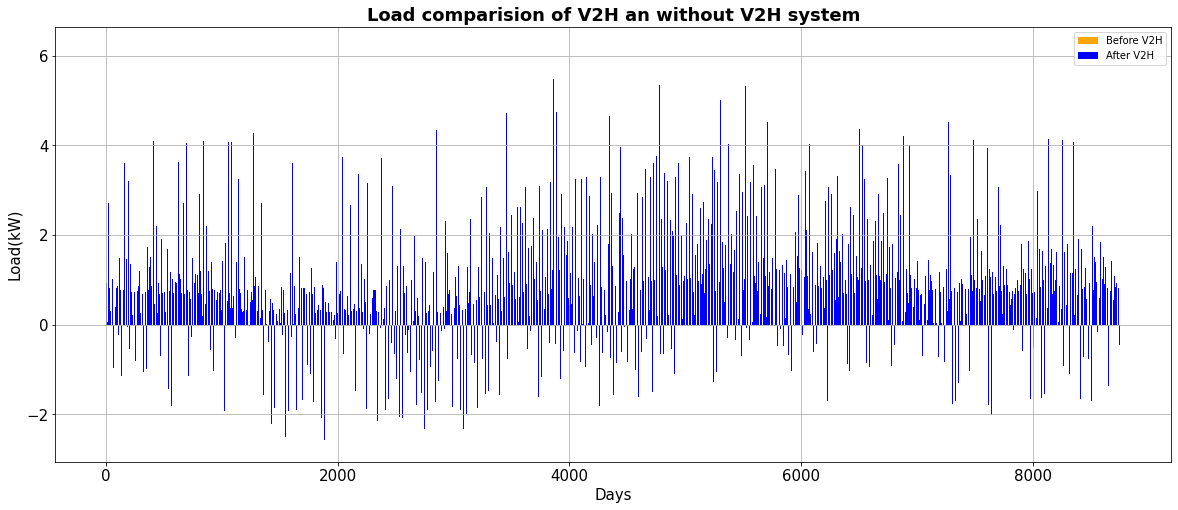

In [ ]:
plt.figure(figsize = (20,8))
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
# plt.xticks(np.arange(0,len(p1), 24), np.arange(1,days+1))

plt.bar(np.arange(len(p1)), p1, color = 'orange', label = 'Before V2H')
plt.bar(np.arange(len(p1)),new_p1, color = 'blue', label = "After V2H")
plt.xlabel("Days", fontsize = 15)
plt.ylabel("Load(kW)", fontsize = 15)
plt.title("Load comparision of V2H an without V2H system", fontsize = 18, fontweight = 'bold')
plt.grid()
plt.legend()
plt.show()